<a href="https://colab.research.google.com/github/TheRadDani/MaskRCNNObjectDetection/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pycocotools --quiet

In [5]:
%%bash
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
cd data && unzip PennFudanPed.zip

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: PennFudanPed/Annotation/FudanPed00014.txt  
  inflating: PennFudanPed/Annotation/FudanPed00015.txt  
  i

--2024-10-30 17:26:55--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

     0K .......... .......... .......... .......... ..........  0%  138K 6m19s
    50K .......... .......... .......... .......... ..........  0%  138K 6m19s
   100K .......... .......... .......... .......... ..........  0%  138K 6m18s
   150K .......... .......... .......... .......... ..........  0% 93.6K 7m3s
   200K .......... .......... .......... .......... ..........  0% 98.8K 7m24s
   250K .......... .......... .......... .......... ..........  0%  115K 7m25s
   300K .......... .......... .......... .......... ..........  0% 83.2K 7m51s
   350K .......... .......... .......... .......... ..........  0

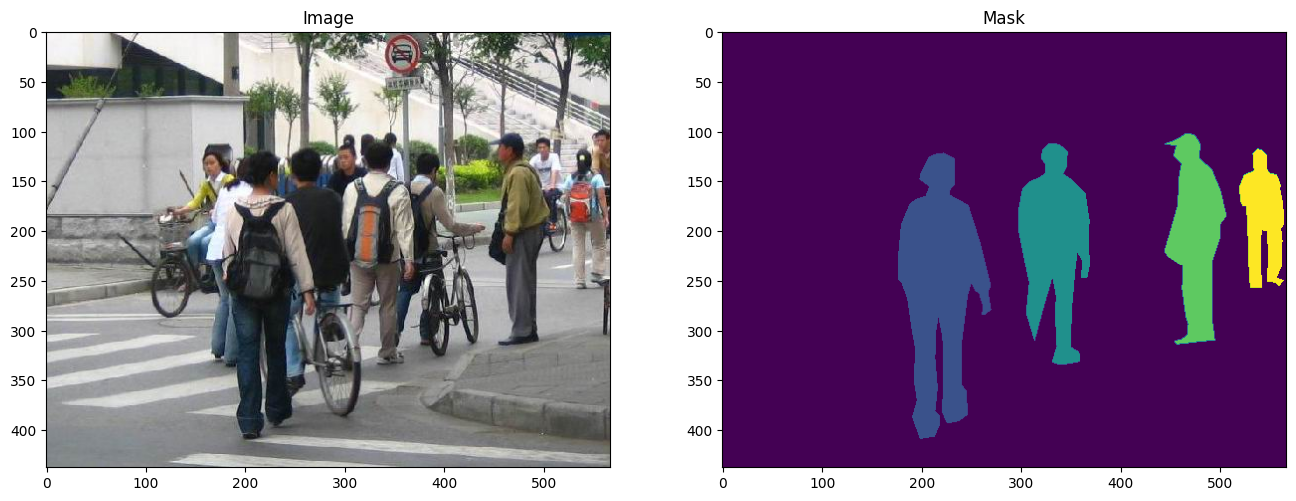

In [6]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("./data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0));

In [7]:
import os
import torch
from typing import Callable, Dict, Tuple, Optional

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root: str, transforms: Optional[Callable] = None) -> None:
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx: int) -> Tuple[tv_tensors.Image, Dict[str, torch.Tensor]]:
    '''Load images and masks'''
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = read_image(img_path)
    mask = read_image(mask_path)
    # instances are encoded as different colors
    obj_ids = torch.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

    # get bounding box coordinates for each mask
    boxes = masks_to_boxes(masks)

    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)

    image_id = idx
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Wrap sample and targets into torchvision tv_tensors:
    img = tv_tensors.Image(img)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
    target["masks"] = tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self) -> int:
    return len(self.imgs)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# parameters for the classifier
num_classes = 2 # 1 class (person) + background
# get the numer of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 177MB/s]


In [9]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Modifying the backbone of the model

In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# return the features of the backbone for classification
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# FasterRCNN needs to know the number of
# output channels in the backbone
backbone.out_channels = backbone[-1].out_channels

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 55.4MB/s]


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN

def get_model_instance_segmentation(numn_classes: int) -> MaskRCNN:

  model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # Replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,
                                                    num_classes)

  # get number of input feautures for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # Replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes,
  )
  return model

In [12]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [13]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [14]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('./data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.3177, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0413, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0613, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0025, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [15]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.005,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 165MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:03:30  lr: 0.000090  loss: 2.0072 (2.0072)  loss_classifier: 0.8340 (0.8340)  loss_box_reg: 0.1031 (0.1031)  loss_mask: 1.0458 (1.0458)  loss_objectness: 0.0239 (0.0239)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 3.5100  data: 0.0201  max mem: 3340
Epoch: [0]  [10/60]  eta: 0:00:48  lr: 0.000936  loss: 0.8427 (1.0544)  loss_classifier: 0.2301 (0.2889)  loss_box_reg: 0.2029 (0.2253)  loss_mask: 0.5142 (0.5220)  loss_objectness: 0.0055 (0.0092)  loss_rpn_box_reg: 0.0090 (0.0089)  time: 0.9766  data: 0.0273  max mem: 4533
Epoch: [0]  [20/60]  eta: 0:00:34  lr: 0.001783  loss: 0.8410 (0.9979)  loss_classifier: 0.1093 (0.2012)  loss_box_reg: 0.1941 (0.1967)  loss_mask: 0.5142 (0.5739)  loss_objectness: 0.0055 (0.0134)  loss_rpn_box_reg: 0.0120 (0.0128)  time: 0.7198  data: 0.0285  max mem: 4534
Epoch: [0]  [30/60]  eta: 0:00:24  lr: 0.002629  loss: 0.7760 (0.9123)  loss_classifier: 0.0929 (0.1749)  loss_box_reg: 0.1507 (0.1782)  loss_mask: 0.4224 (0.5279)  loss_ob

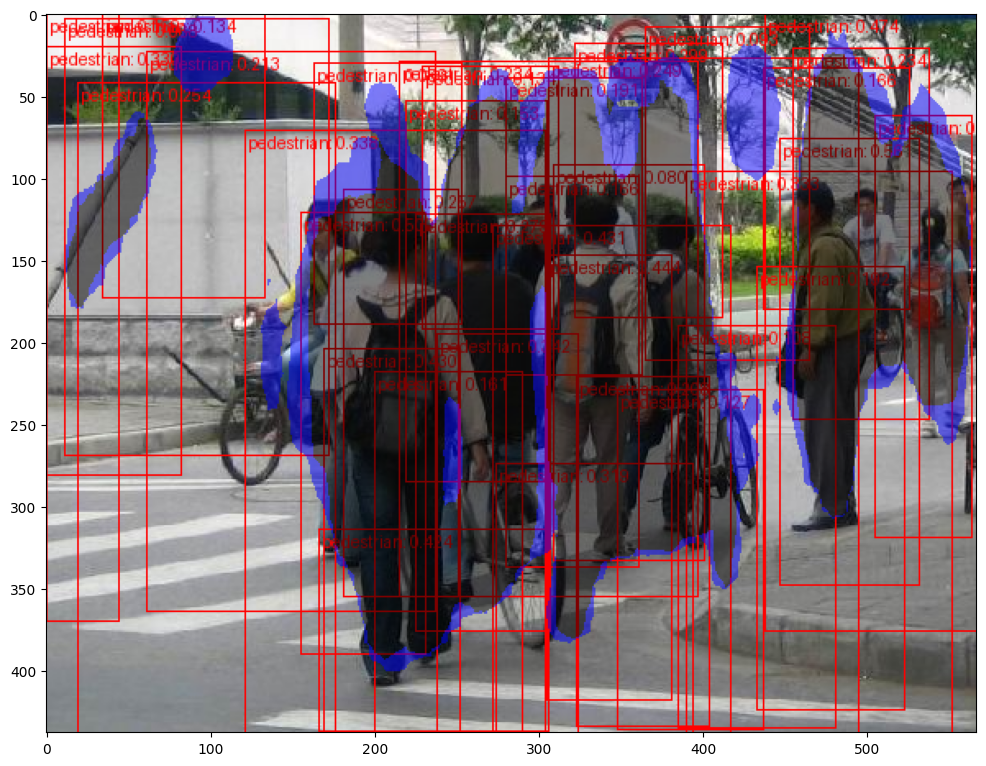

In [16]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))